<a href="https://colab.research.google.com/github/abdulganiyMK007/freeCodeCamp-Project-Files/blob/master/fcc_cat_dog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [62]:
try:
  # This command only in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [2]:
# Get project files
!wget https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip

!unzip cats_and_dogs.zip

PATH = 'cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

# Variables for pre-processing and training.
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

Streaming output truncated to the last 5000 lines.
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.60.jpg  
  inflating: cats_and_dogs/train/dogs/dog.858.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.858.jpg  
  inflating: cats_and_dogs/train/dogs/dog.680.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.680.jpg  
  inflating: cats_and_dogs/train/dogs/dog.694.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.694.jpg  
  inflating: cats_and_dogs/train/dogs/dog.864.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.864.jpg  
  inflating: cats_and_dogs/train/dogs/dog.870.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.870.jpg  
  inflating: cats_and_dogs/train/dogs/dog.871.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.871.jpg  
  inflating: cats_and_dogs/train/dogs/dog.865.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.865.jpg  
  inflating: cats_and_dogs/train/dogs/dog.695.jpg  
  inflating: __MACOSX/cats_and

In [45]:
train_image_generator = ImageDataGenerator(rescale=1./255)
validation_image_generator = ImageDataGenerator(rescale=1./255)
test_image_generator = ImageDataGenerator(rescale=1./255)

train_data_gen = train_image_generator.flow_from_directory(
    directory=train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=batch_size,
    class_mode='binary',
)

val_data_gen = validation_image_generator.flow_from_directory(
    directory=validation_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=batch_size,
    class_mode='binary',
)


# Get a list of all image paths in the test directory
test_images = [f for f in os.listdir(test_dir) if f.endswith('.png') or f.endswith('.jpg')]
filepaths = [os.path.join(test_dir, fname) for fname in test_images]

# Create a DataFrame with file paths and dummy labels
test_df = pd.DataFrame({
    'filename': test_images,
    'class': ['unknown'] * len(test_images)  # Placeholder for class; not used in prediction
})

test_data_gen = test_image_generator.flow_from_dataframe(
    dataframe=test_df,
    directory=test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=batch_size,
    class_mode=None,  # No labels
    shuffle=False
)


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 validated image filenames.


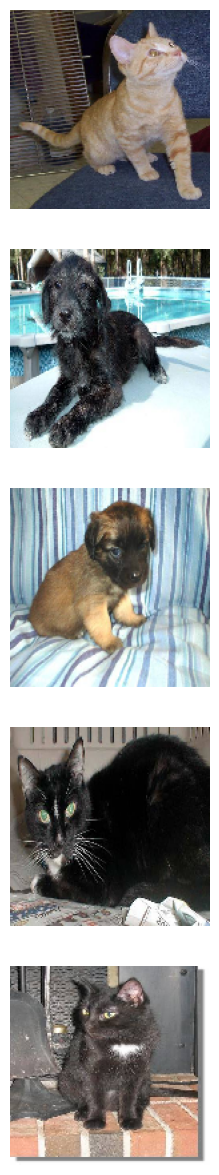

In [6]:
# 4
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
    if probabilities is False:
      for img, ax in zip( images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
    else:
      for img, probability, ax in zip( images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
          if probability > 0.5:
              ax.set_title("%.2f" % (probability*100) + "% dog")
          else:
              ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
    plt.show()

sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])


In [7]:
# 5
train_image_generator = train_image_generator = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    height_shift_range=0.1,
    width_shift_range=0.1,
    brightness_range=(0.5,1.5),
    zoom_range = [1, 1.5])


Found 2000 images belonging to 2 classes.


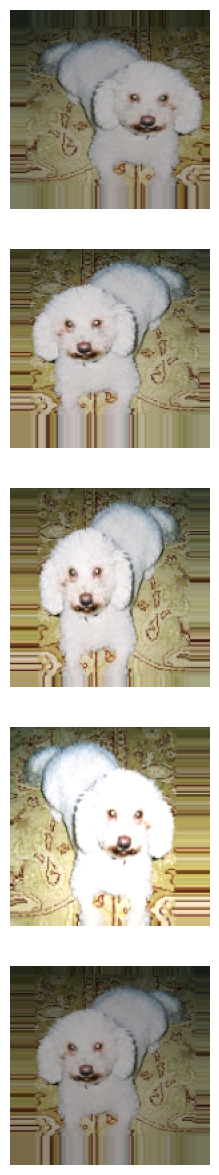

In [8]:
# 6
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

plotImages(augmented_images)

# Using a Pretrained Model

## Create the base model from the pre-trained convnets

In [75]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH) + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

<ipython-input-75-d465b55f5672>:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,


In [76]:
image_batch, label_batch = next(iter(train_data_gen))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(128, 5, 5, 1280)


In [77]:
print(type(train_data_gen))

<class 'keras.src.legacy.preprocessing.image.DirectoryIterator'>


## Feature Extraction

### Freeze convolutional base

In [78]:
# freeze the convolutional base
base_model.trainable = False

### Add classification head

In [79]:

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(128, 1280)


In [80]:
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(128, 1)


In [81]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = base_model(inputs, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
pre_model = tf.keras.Model(inputs, outputs)

In [82]:
pre_model.summary()

Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)           │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 5, 5, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │           1,281 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [83]:
len(pre_model.trainable_variables)

2

In [84]:
# tf.keras.utils.plot_model(model, show_shapes=True)

## Compile the Model

In [85]:
base_learning_rate = 0.0001
pre_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])

## Train the Model

In [86]:
loss0, accuracy0 = pre_model.evaluate(val_data_gen)

8/8 ━━━━━━━━━━━━━━━━━━━━ 36s 4s/step - accuracy: 0.4876 - loss: 0.9709


In [87]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.95
initial accuracy: 0.49


In [88]:
history = pre_model.fit(train_data_gen,
                    epochs=10,
                    validation_data=val_data_gen)

Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 95s 6s/step - accuracy: 0.5073 - loss: 0.9595 - val_accuracy: 0.5670 - val_loss: 0.7582
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 141s 5s/step - accuracy: 0.5844 - loss: 0.7707 - val_accuracy: 0.6700 - val_loss: 0.6346
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 68s 4s/step - accuracy: 0.6607 - loss: 0.6763 - val_accuracy: 0.7410 - val_loss: 0.5393
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 68s 4s/step - accuracy: 0.7366 - loss: 0.5562 - val_accuracy: 0.7910 - val_loss: 0.4685
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 72s 5s/step - accuracy: 0.7652 - loss: 0.4865 - val_accuracy: 0.8260 - val_loss: 0.4127
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 68s 4s/step - accuracy: 0.7857 - loss: 0.4602 - val_accuracy: 0.8420 - val_loss: 0.3696
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 70s 4s/step - accuracy: 0.8212 - loss: 0.4105 - val_accuracy: 0.8650 - val_loss: 0.3354
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 74s 4s/step - accuracy: 0.8414 - loss: 0.3797 - val_accuracy: 0.8830 - val_loss

## Learning Curves

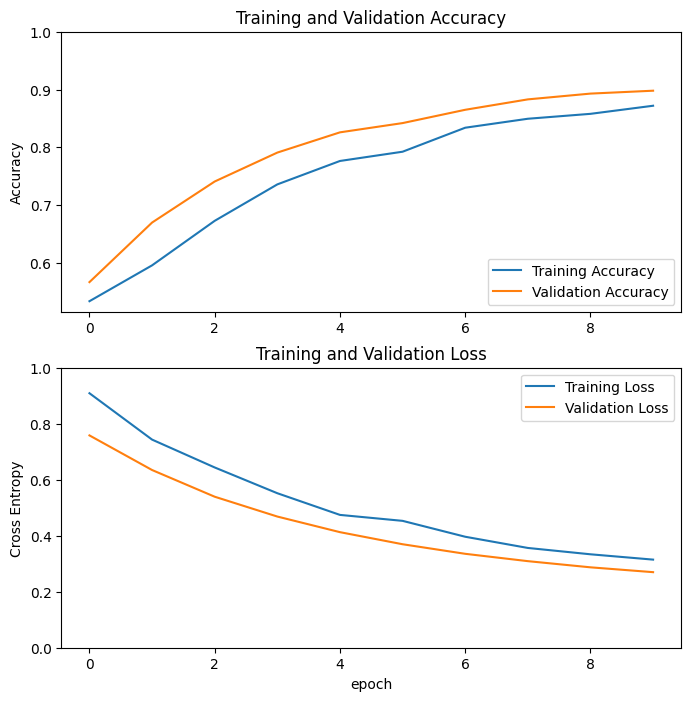

In [89]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Using a ConvNet

In [66]:
# 7
cnn_model = Sequential()

cnn_model.add(Input(shape=(IMG_HEIGHT,IMG_WIDTH,3)))

cnn_model.add(Conv2D(32, (3, 3), activation='relu'))
cnn_model.add(MaxPooling2D(2, 2))

cnn_model.add(Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(MaxPooling2D(2, 2))

cnn_model.add(Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(MaxPooling2D(2, 2))

cnn_model.add(Flatten())

cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(1, activation='sigmoid'))


In [68]:
cnn_model.compile(tf.keras.optimizers.Adam(
        # learning_rate=5e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-05, weight_decay=1e-7 # : 56%
        # learning_rate=1e-5, beta_1=0.9, beta_2=0.999, epsilon=1e-06, weight_decay=None # : 62%
        # learning_rate=0.0001, beta_1=0.9, beta_2=0.995, epsilon=1e-07, weight_decay=None # : 50%
        learning_rate=0.0001, beta_1=0.85, beta_2=0.99, epsilon=1e-08, weight_decay=None # : 62%
    ),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=['accuracy'])

cnn_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 36992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │       4,735,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,828,481 (18.42 MB)

 Trainable params: 4,828,481 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

In [69]:
# 8

history = cnn_model.fit(
    x=train_data_gen,
    steps_per_epoch=len(train_data_gen) // batch_size,  # Number of steps per epoch
    epochs=10,                                          # Total number of epochs
    validation_data=val_data_gen,                       # Validation data
    validation_steps=len(val_data_gen) // batch_size,   # Steps per validation epoch
)

Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.5116 - loss: 0.6963

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


16/16 ━━━━━━━━━━━━━━━━━━━━ 126s 8s/step - accuracy: 0.5124 - loss: 0.6961 - val_accuracy: 0.5400 - val_loss: 0.6852
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 136s 7s/step - accuracy: 0.5518 - loss: 0.6840 - val_accuracy: 0.6350 - val_loss: 0.6749
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 121s 8s/step - accuracy: 0.5882 - loss: 0.6762 - val_accuracy: 0.6070 - val_loss: 0.6699
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 143s 8s/step - accuracy: 0.6273 - loss: 0.6635 - val_accuracy: 0.6600 - val_loss: 0.6475
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 123s 8s/step - accuracy: 0.6673 - loss: 0.6331 - val_accuracy: 0.6680 - val_loss: 0.6288
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 141s 7s/step - accuracy: 0.6730 - loss: 0.6218 - val_accuracy: 0.6530 - val_loss: 0.6179
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 141s 7s/step - accuracy: 0.6790 - loss: 0.6008 - val_accuracy: 0.6980 - val_loss: 0.5989
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 137s 7s/step - accuracy: 0.6944 - loss: 0.5909 - val_accuracy: 0.7020 - val_loss: 0.

# Predictions

In [70]:
# 11
def predict_func(probabilities):
  answers =  [0, 0, 0, 0, 0, 1, 1, 0, 1, 1,
              1, 1, 0, 0, 1, 0, 1, 0, 1, 1,
              0, 1, 1, 0, 1, 1, 0, 1, 0, 1,
              0, 1, 1, 1, 1, 0, 0, 1, 0, 0,
              0, 0, 1, 0, 0, 1, 0, 0, 0, 1]

  correct = 0

  for probability, answer in zip(probabilities, answers):
    if round(probability) == answer:
      correct +=1

  percentage_identified = (correct / len(answers)) * 100

  passed_challenge = percentage_identified >= 63

  print(f"Your model correctly identified {round(percentage_identified, 2)}% of the images of cats and dogs.")

  if passed_challenge:
    print("You passed the challenge!")
  else:
    print("You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!")

## Pretrainded Model Predictions

In [90]:
predictions = pre_model.predict(test_data_gen)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


In [91]:
probabilities = (predictions > 0.5).astype(int)
probabilities = probabilities.flatten().tolist()
print(probabilities)

[0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1]


In [92]:
predict_func(probabilities)

Your model correctly identified 90.0% of the images of cats and dogs.
You passed the challenge!


## Convet Model Predictions

In [93]:
predictions = cnn_model.predict(test_data_gen)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 771ms/step


In [94]:
probabilities = (predictions > 0.5).astype(int)
probabilities = probabilities.flatten().tolist()
print(probabilities)

[0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1]


In [95]:
predict_func(probabilities)

Your model correctly identified 70.0% of the images of cats and dogs.
You passed the challenge!
